Importing the necessary libraries


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage import data, exposure
from skimage.color import rgb2gray
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.transform import resize
from concurrent.futures import ProcessPoolExecutor
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Model 1 - SVM with HoG features


In [11]:
# Load the datasets
X_data = np.load('/Users/nikhilmacbook/Desktop/Machine Learning Course Work/DS_Xdata.npy')
Y_data = np.load('/Users/nikhilmacbook/Desktop/Machine Learning Course Work/Ydata.npy')


# Function to extract HoG features
def compute_hog_features(X):
    # If the input is already processed (1D array)
    if len(X.shape) == 2 and X.shape[1] == 1296:  # If already HOG features
        return X
    
    # If the input is a 1D array, reshape it to 2D
    if len(X.shape) == 1:
        return X.reshape(1, -1)
    
    hog_features = []
    for img in X:
        # Skip HOG computation if the image is already processed
        if len(img.shape) == 1:
            hog_features.append(img)
            continue
            
        # Process image if it's not already processed
        if len(img.shape) == 3:  # RGB image
            gray_img = rgb2gray(img)
        else:  # Already grayscale
            gray_img = img
            
        feature, _ = hog(gray_img, 
                        pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2),
                        visualize=True)
        hog_features.append(feature)
    
    return np.array(hog_features)

# Extract HOG features from the dataset
features = compute_hog_features(X_data)

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Flatten y to ensure it's a 1D array
y_flattened = Y_data.ravel()

# Split the data into train and temporary sets (90% train, 10% temp)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y_data, test_size=0.2, stratify=Y_data, random_state=42)

# Split the temporary set into validation and test sets (50% val, 50% test of 20% temp => 10% val, 10% test)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")

# Print dataset sizes to verify correct splits
print("Total number of samples:", len(X_data))
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Training data: (1680, 61, 61, 3), Validation data: (210, 61, 61, 3), Test data: (210, 61, 61, 3)
Total number of samples: 2100
Train set size: 1680
Validation set size: 210
Test set size: 210


Train HOG: (1680, 1296), Validation HOG: (210, 1296), Test HOG: (210, 1296)
Train HOG Scaled: (1680, 1296), Validation HOG Scaled: (210, 1296), Test HOG Scaled: (210, 1296)
Model 1 - SVM (5 classes)
Training Accuracy: 100.00%
Validation Accuracy: 58.82%
Test Accuracy: 66.67%


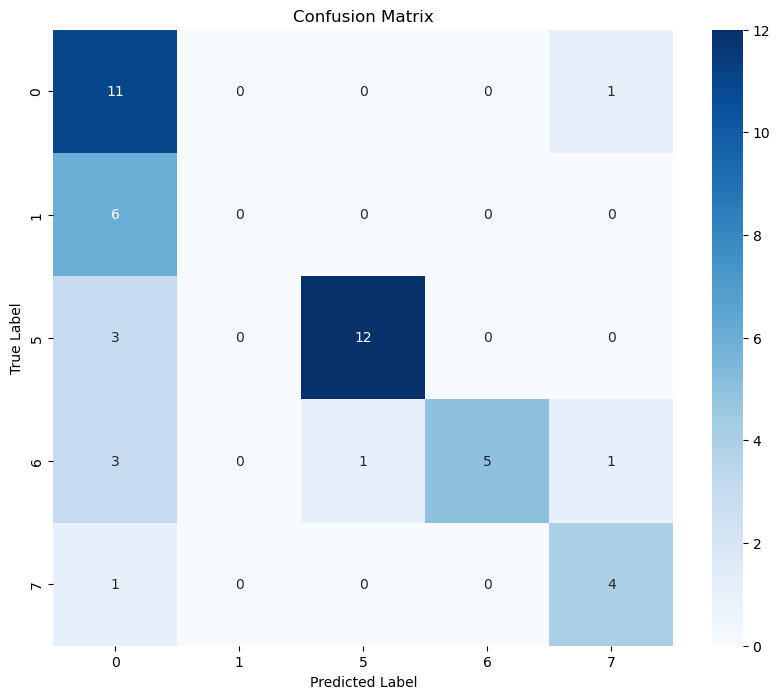

In [15]:
selected_classes = [0, 1, 5, 6, 7]
train_indices = np.isin(Y_train, selected_classes).flatten()
val_indices = np.isin(Y_val, selected_classes).flatten()
test_indices = np.isin(Y_test, selected_classes).flatten()

# Extract HoG Features
X_train_hog = compute_hog_features(X_train)
X_val_hog = compute_hog_features(X_val)
X_test_hog = compute_hog_features(X_test)

print(f"Train HOG: {X_train_hog.shape}, Validation HOG: {X_val_hog.shape}, Test HOG: {X_test_hog.shape}")

# Scale Features
scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_val_hog_scaled = scaler.transform(X_val_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

print(f"Train HOG Scaled: {X_train_hog_scaled.shape}, Validation HOG Scaled: {X_val_hog_scaled.shape}, Test HOG Scaled: {X_test_hog_scaled.shape}")


# Filter data for the selected classes
X_train_5 = X_train[train_indices]
Y_train_5 = Y_train[train_indices]
X_val_5 = X_val[val_indices]
Y_val_5 = Y_val[val_indices]
X_test_5 = X_test[test_indices]
Y_test_5 = Y_test[test_indices]

# Reshape the data to 2D format (samples, features)
X_train_5_reshaped = X_train_5.reshape(X_train_5.shape[0], -1)
X_val_5_reshaped = X_val_5.reshape(X_val_5.shape[0], -1)
X_test_5_reshaped = X_test_5.reshape(X_test_5.shape[0], -1)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_5_reshaped, Y_train_5.ravel())

# Evaluate SVM
svm_predictions = svm_classifier.predict(X_test_5_reshaped)
svm_train_accuracy = accuracy_score(Y_train_5, svm_classifier.predict(X_train_5_reshaped))
svm_test_accuracy = accuracy_score(Y_test_5, svm_predictions)
svm_val_accuracy = accuracy_score(Y_val_5, svm_classifier.predict(X_val_5_reshaped))

# Print results
print("Model 1 - SVM (5 classes)")
print(f"Training Accuracy: {svm_train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {svm_val_accuracy*100:.2f}%")
print(f"Test Accuracy: {svm_test_accuracy*100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test_5, svm_predictions, labels=selected_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=selected_classes,yticklabels=selected_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Model 2 - HOG + PCA + SVM for 5 classes

Model 2 - HOG + PCA + SVM (5 classes)
Training Accuracy: 94.50%
Validation Accuracy: 88.00%
Test Accuracy: 78.00%


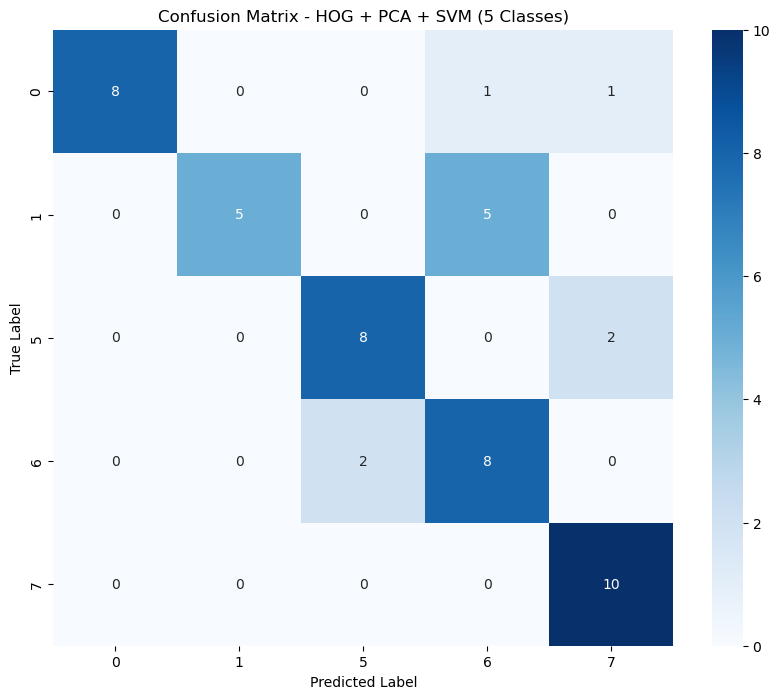

In [13]:
# Model 2: HOG + PCA + SVM for 5 selected classes

# Use the same selected classes as in Model 1
selected_classes = [0, 1, 5, 6, 7]

# Filter data for selected classes
train_indices = np.isin(Y_train, selected_classes).flatten()
val_indices = np.isin(Y_val, selected_classes).flatten()
test_indices = np.isin(Y_test, selected_classes).flatten()

# 1. Extract HOG features
X_train_hog = compute_hog_features(X_train[train_indices])
X_val_hog = compute_hog_features(X_val[val_indices])
X_test_hog = compute_hog_features(X_test[test_indices])

# Get corresponding labels
Y_train_filtered = Y_train[train_indices]
Y_val_filtered = Y_val[val_indices]
Y_test_filtered = Y_test[test_indices]

# 2. Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduce to 50 components
X_train_pca = pca.fit_transform(X_train_hog)
X_val_pca = pca.transform(X_val_hog)
X_test_pca = pca.transform(X_test_hog)

# 3. Train SVM with the reduced features
svm_pca = SVC(kernel='rbf', random_state=42)
svm_pca.fit(X_train_pca, Y_train_filtered.ravel())

# 4. Evaluate the model
train_predictions = svm_pca.predict(X_train_pca)
val_predictions = svm_pca.predict(X_val_pca)
test_predictions = svm_pca.predict(X_test_pca)

# Calculate accuracies
train_accuracy = accuracy_score(Y_train_filtered, train_predictions)
val_accuracy = accuracy_score(Y_val_filtered, val_predictions)
test_accuracy = accuracy_score(Y_test_filtered, test_predictions)

# Print results
print("Model 2 - HOG + PCA + SVM (5 classes)")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(Y_test_filtered, test_predictions, labels=selected_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.title('Confusion Matrix - HOG + PCA + SVM (5 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model 3 - CNN for all classes

Epoch 1/100


/Users/nikhilmacbook/micromamba/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nikhilmacbook/micromamba/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.0928 - loss: 3.8806 - val_accuracy: 0.0429 - val_loss: 4.9253 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.2060 - loss: 2.9787 - val_accuracy: 0.0476 - val_loss: 6.6564 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.2679 - loss: 2.5384 - val_accuracy: 0.0476 - val_loss: 10.0621 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.2830 - loss: 2.3899 - val_accuracy: 0.0714 - val_loss: 6.4894 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.3004 - loss: 2.3119 - val_accuracy: 0.0476 - val_loss: 8.1528 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - accuracy: 0.3165 - loss: 2.1526 - val_accuracy: 0.0714 - val_loss: 7.4793 - learning_rate: 0.0010
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 334ms/step - accuracy: 0.3623 - loss: 1.9669

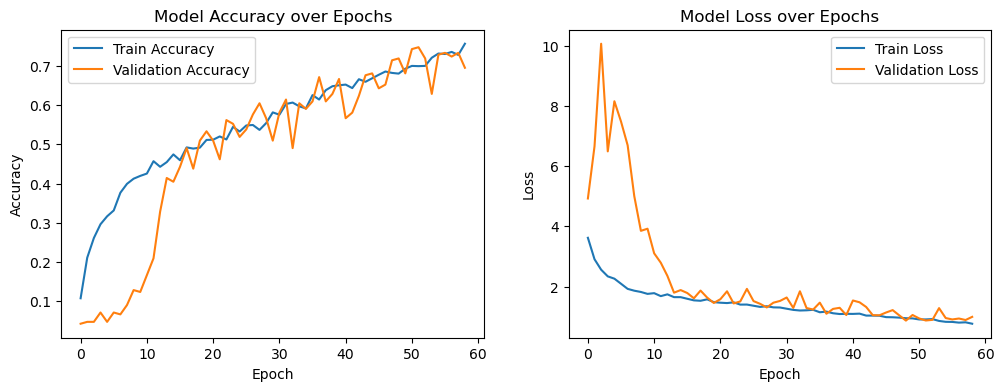

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Class 0 Accuracy: 100.00%
Class 1 Accuracy: 83.33%
Class 2 Accuracy: 87.50%
Class 3 Accuracy: 76.92%
Class 4 Accuracy: 38.46%
Class 5 Accuracy: 100.00%
Class 6 Accuracy: 90.00%
Class 7 Accuracy: 80.00%
Class 8 Accuracy: 66.67%
Class 9 Accuracy: 16.67%
Class 10 Accuracy: 100.00%
Class 11 Accuracy: 87.50%
Class 12 Accuracy: 28.57%
Class 13 Accuracy: 71.43%
Class 14 Accuracy: 76.92%
Class 15 Accuracy: 100.00%
Class 16 Accuracy: 100.00%
Class 17 Accuracy: 100.00%
Class 18 Accuracy: 77.78%
Class 19 Accuracy: 16.67%
Class 20 Accuracy: 12.50%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


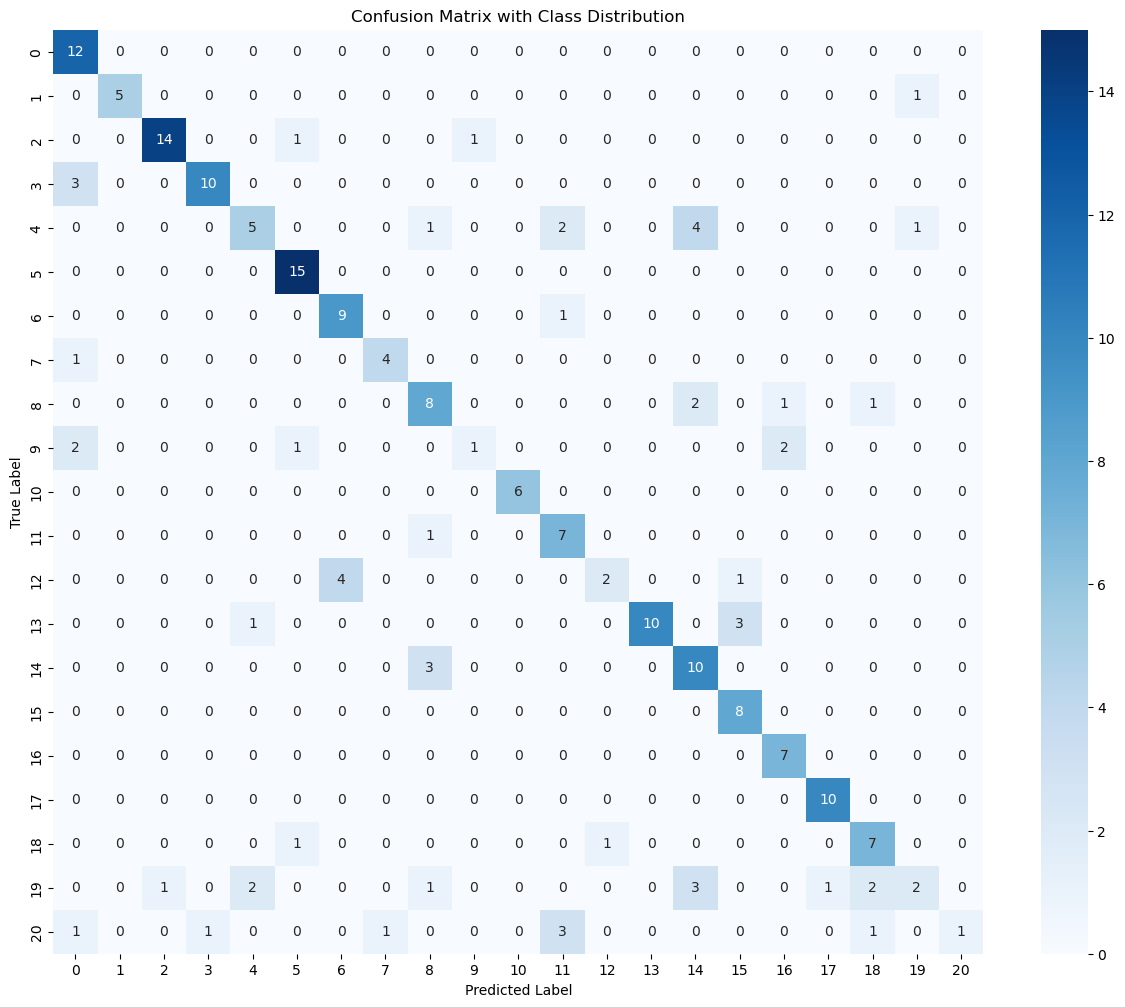

In [14]:
# Task 3: Model Analysis Strategy 3
# Load the data
X_data = np.load('/Users/nikhilmacbook/Desktop/Machine Learning Course Work/DS_Xdata.npy')
Y_data = np.load('/Users/nikhilmacbook/Desktop/Machine Learning Course Work/Ydata.npy')

# Split the data
X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Then normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to categorical
Y_train_cat = to_categorical(Y_train, num_classes=21)
Y_val_cat = to_categorical(Y_val, num_classes=21)
Y_test_cat = to_categorical(Y_test, num_classes=21)


# Build  CNN model
cnn = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(61, 61, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(21, activation='softmax')
])

# Compile with optimized parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Early Stopping and Model Checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model
history = cnn.fit(
    datagen.flow(X_train, Y_train_cat, batch_size=32),
    validation_data=(X_val, Y_val_cat),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
train_loss, train_accuracy = cnn.evaluate(X_train, Y_train_cat)
val_loss, val_accuracy = cnn.evaluate(X_val, Y_val_cat)
test_loss, test_accuracy = cnn.evaluate(X_test, Y_test_cat)

# Print results
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix and Class-wise Analysis
Y_pred = np.argmax(cnn.predict(X_test), axis=-1)
Y_test_labels = np.argmax(Y_test_cat, axis=-1)

# Calculate per-class metrics
class_accuracies = []
for i in range(21):
    class_mask = Y_test_labels == i
    if np.any(class_mask):
        class_acc = accuracy_score(Y_test_labels[class_mask], Y_pred[class_mask])
        class_accuracies.append(class_acc * 100)
        print(f"Class {i} Accuracy: {class_acc*100:.2f}%")
# Confusion Matrix
Y_pred = np.argmax(cnn.predict(X_test), axis=-1)
Y_test_labels = np.argmax(Y_test_cat, axis=-1)
conf_matrix = confusion_matrix(Y_test_labels, Y_pred)

plt.figure(figsize=(15, 12))
conf_matrix = confusion_matrix(Y_test_labels, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(21), yticklabels=range(21))
plt.title('Confusion Matrix with Class Distribution')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()